In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import scqubits as scq
import scqubits.utils.sweep_plotting as splot
from scqubits import HilbertSpace, InteractionTerm, ParameterSweep

import numpy as np
import qutip as qt

# Working with composite Hilbert spaces and interfacing with QuTiP

Systems of interest for quantum information processing will involve multiple qubits as well as oscillators with mutual coupling. The resulting Hilbert space is the tensor product of the individual constituent Hilbert spaces. The `HilbertSpace` class allows one to define such coupled systems, to define the interactions between them, and to contruct the overall Hamiltonian. From this, dressed eigenenergies and eigenstates can be extracted. The operator matrices and state vectors  at the `HilbertSpace` level are given as QuTiP `Qobj` instances. This interface to QuTiP is particularly helpful if the task at hand is the simulation of time-dependent dynamics of the coupled system, perhaps including additional drive terms.

## Example: two transmon qubits coupled capacitively to one resonator mode

A simple but useful example of a coupled quantum system is the case of two transmons, each coupled capacitively to a standing-wave mode inside a microwave resonator. The Hamiltonian describing this composite system is given by

$\displaystyle H=\sum_{\alpha=1,2}\sum_{j} E_j^{(\alpha)}| j^{(\alpha)}\rangle\langle  j^{(\alpha)}| + \omega_r a^\dagger a + \sum_{\alpha=1,2}g^{(\alpha)} n_\alpha(a+a^\dagger)$,

where $\alpha=1,2$ labels the two transmons; $E_j^\alpha$ and $|j^{(\alpha)} \rangle$ are  the $j$-th eigenenergy and corresponding eigenstate of qubit $\alpha$. Resonator photons with (angular) frequency $\omega$ are created by the usual ladder operator $a^\dagger$. The resonator-transmon coupling is facilitated by the interaction between the qubit's dipolar charge $n_\alpha$ and the resonator's electric field $\sim a+a^\dagger$, and $g^{(\alpha)}$ parametrizes the coupling strength.

### Define Hilbert space components, initialize `HilbertSpace` object

To set up the Hilbert space of two transmons and one resonator, we first define the separate components and then initialize a `HilbertSpace` object by submitting the list of all three subsystems:

In [2]:
# Set up the components / subspaces of our Hilbert space

CPB1 = scq.Transmon(
    EJ = 40.0,
    EC = 0.2,
    ng = 0.3,
    ncut = 40,
    truncated_dim = 3     # after diagonalization, we will keep 3 levels
)

CPB2 = scq.Transmon(
    EJ = 30.0,
    EC = 0.15,
    ng = 0.0,
    ncut = 10,
    truncated_dim = 4
)

resonator = scq.Oscillator(
    E_osc = 6.0,
    truncated_dim=4  # up to 3 photons (0,1,2,3)
)


# Form a list of all components making up the Hilbert space.
hilbertspace = HilbertSpace([CPB1, CPB2, resonator])

In [3]:
print(hilbertspace)

====== HilbertSpace object ======

TRANSMON
 ———— PARAMETERS ————
EJ	: 40.0
EC	: 0.2
ng	: 0.3
ncut	: 40
truncated_dim	: 3
Hilbert space dimension	: 81

TRANSMON
 ———— PARAMETERS ————
EJ	: 30.0
EC	: 0.15
ng	: 0.0
ncut	: 10
truncated_dim	: 4
Hilbert space dimension	: 21

OSCILLATOR
 ———— PARAMETERS ————
truncated_dim	: 4
E_osc	: 6.0
Hilbert space dimension	: 4



While we yet have to set up the interactions between the components, we can already obtain the bare Hamiltonian of the non-interacting subsystems, expressed as a matrix in the joint Hilbert space:

In [4]:
bare_hamiltonian = hilbertspace.bare_hamiltonian()
bare_hamiltonian

Quantum object: dims = [[3, 4, 4], [3, 4, 4]], shape = (48, 48), type = oper, isherm = True
Qobj data =
[[-63.0886372    0.           0.         ...   0.           0.
    0.        ]
 [  0.         -57.0886372    0.         ...   0.           0.
    0.        ]
 [  0.           0.         -51.0886372  ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... -24.66024074   0.
    0.        ]
 [  0.           0.           0.         ...   0.         -18.66024074
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  -12.66024074]]

The Hamiltonian matrix is given in the form of a QuTiP quantum object which facilitates simple incorporation of Hamiltonians generated with `scqubits` into any of the solvers QuTiP offers for time evolution.

In [5]:
type(bare_hamiltonian)

qutip.qobj.Qobj

### Set up interaction terms between individual subsystems

In [6]:
g1 = 0.1  # coupling resonator-CPB1 (without charge matrix elements)
g2 = 0.2  # coupling resonator-CPB2 (without charge matrix elements)

interaction1 = InteractionTerm(
    g_strength = g1,
    op1 = CPB1.n_operator(),
    subsys1 = CPB1,
    op2 = resonator.creation_operator() + resonator.annihilation_operator(),
    subsys2 =resonator
)

interaction2 = InteractionTerm(
    g_strength = g2,
    op1 = CPB2.n_operator(),
    subsys1 = CPB2,
    op2 = resonator.creation_operator() + resonator.annihilation_operator(),
    subsys2 =resonator
)

Now insert the interaction terms into the HilbertSpace object.

In [7]:
interaction_list = [interaction1, interaction2]

hilbertspace.interaction_list = interaction_list

Now that the interactions are specified, the full Hamiltonian of the coupled system can be obtained via:

In [8]:
dressed_hamiltonian = hilbertspace.hamiltonian()
dressed_hamiltonian

Quantum object: dims = [[3, 4, 4], [3, 4, 4]], shape = (48, 48), type = oper, isherm = True
Qobj data =
[[-6.30886372e+01  3.00000000e-02  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.00000000e-02 -5.70886372e+01  4.24264069e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.24264069e-02 -5.10886372e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.46602407e+01
   4.24264069e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.24264069e-02
  -1.86602407e+01  5.19615242e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   5.19615242e-02 -1.26602407e+01]]

In [9]:
np.max(np.abs(dressed_hamiltonian - dressed_hamiltonian.dag()))

0.0

Since the composite Hamiltonian is a `scq.Qobj`, The eigenvalues and eigenvectors can be now be obtained via the usual QuTiP routine:

In [10]:
evals, evecs = dressed_hamiltonian.eigenstates(eigvals=4)
print(evals)

[-63.09882162 -57.51117008 -56.87227527 -55.29218444]


### Spectrum lookup and converting between bare and dressed indices

To use lookup functions for state indices, energies and states, first generate the lookup table via:

In [11]:
hilbertspace.generate_lookup()

Here are the bare energies of the first Cooper pair box system:

In [12]:
hilbertspace.lookup.bare_eigenenergies(CPB1)

array([-36.05064983, -28.25601136, -20.67410141])

The dressed state with index j=3 corresponds to following bare product state:

In [13]:
hilbertspace.lookup.bare_index(8)

(1, 0, 1)

And the bare product state (1,2,1) most closely matches the following dressed state:

In [14]:
hilbertspace.lookup.dressed_index((1,2,1))

21

In [15]:
hilbertspace.lookup.energy_dressed_index(10)

-46.531421872236486

In [16]:
hilbertspace.lookup.bare_eigenstates(CPB1);

# Sweeping over an external parameter

scqubits provides the class `ParameterSweep` to facilitate computation of spectra as function of an external parameter. For efficient usage in the `Explorer` class, computed bare and dressed spectral data are stored internally. A sweep object is initialized as follows.

Consider the case where both `CPB1` and `CPB2` subsystems are flux-tunable split-junction transmons with different loop areas. 

In [17]:
param_name = 'flux'                          # name of varying external parameter
param_vals = np.linspace(0., 2.0, 200)     # parameter values

subsys_update_list = [CPB1, CPB2]                  # list of HilbertSpace subsystems which are affected by parameter changes         

def update_hilbertspace(param_val):     # function that shows how Hilbert space components are updated
    CPB1.EJ = 20*np.abs(np.cos(np.pi * param_val))
    CPB2.EJ = 15*np.abs(np.cos(np.pi * param_val * 0.65))

    
sweep = ParameterSweep(
    param_name=param_name,
    param_vals=param_vals,
    evals_count=20,
    hilbertspace=hilbertspace,
    subsys_update_list=subsys_update_list,
    update_hilbertspace=update_hilbertspace
)


Once the data has been generated, the spectrum can be plotted as a function of the parameter value:

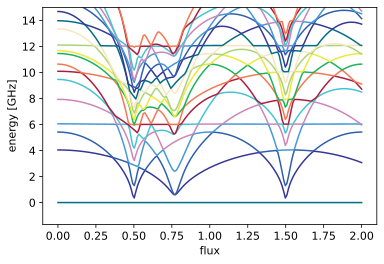

In [18]:
splot.dressed_spectrum(sweep);

In [19]:
del hilbertspace


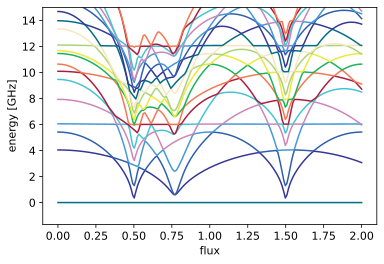

In [20]:
splot.dressed_spectrum(sweep);

In [9]:
sweep.filewrite('./sweep-test.h5')

In [25]:
storedsweep = scq.read('./sweep-test.h5')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x17d5463c8d0>)

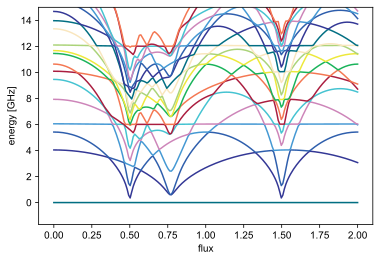

In [26]:
splot.dressed_spectrum(storedsweep)

In [12]:
hspace_stored = storedsweep.get_hilbertspace()

In [13]:
[tmon1, tmon2, osc] = hspace_stored

In [14]:
storedsweep.lookup.bare_eigenenergies(tmon1)

array([-17.22250771, -11.7734806 ,  -6.54355219])

In [15]:
storedsweep.lookup.bare_index(9)

(0, 3, 0)

In [33]:
storedsweep.lookup.energy_dressed_index(10,100)

-11.4885409217044